In [ ]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt
import fnmatch
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from PIL import Image

import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')

#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Mounted at /content/drive


In [ ]:
dim=(256, 32)
def im_resize(input_image):
    #f=cv2.transpose(input_image)
    im_resize=cv2.resize(input_image, dim)
    return im_resize

In [ ]:
valid_x = []
train_x = []
train=[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab_Notebooks/Nega/line-images/'):
    for filename in filenames:
        train.append(os.path.join(dirname, filename))
for i in range(len(train)):
    im= cv2.imread(train[i], cv2.IMREAD_GRAYSCALE)
    im = cv2.adaptiveThreshold(im,170,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,25,15)
    image = im_resize(im)
    image = image/255.
    if i%10 == 0:     
        valid_x.append(image)
    else:
        train_x.append(image)

In [ ]:
import glob
from skimage.filters import sobel
from skimage.util import invert
from skimage.color import rgb2gray
imgs=[]
ims=[]
img_list = sorted(glob.glob('/content/drive/MyDrive/Colab_Notebooks/Nega/line-images/*.PNG'))
for i, img_path in enumerate(img_list):
  ims=cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  th2 = cv2.adaptiveThreshold(ims,170,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,25,15)
  imgs.append(th2)

In [ ]:
train_x = []
valid_x = []

for i in range(len(imgs)):
    image = im_resize(imgs[i])
    image = image/255.
    if i%10 == 0:     
        valid_x.append(image)
    else:
        train_x.append(image)


(32, 256)

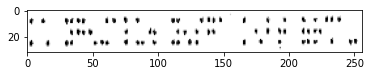

In [ ]:
len(valid_x)
plt.imshow(valid_x[0], cmap='gray')
valid_x[100].shape

In [ ]:
max_label_len = 0

char_list =' ሀሁሂሃሄህሆለሉሊላሌልሎሐሑሒሓሔሕሖመሙሚማሜምሞሰሱሲሳሴስሶረሩሪራሬርሮሠሡሢሣሤሥሦሸሹሺሻሼሽሾቀቁቂቃቄቅቆበቡቢባቤብቦተቱቲታቴትቶቸቹቺቻቼችቾኀኁኂኃኄኅኆነኑኒናኔንኖኘኙኚኛኜኝኞአኡኢኣኤእኦከኩኪካኬክኮኸኹኺኻኼኽኾወዉዊዋዌውዎዐዑዒዓዔዕዖዘዙዚዛዜዝዞዠዡዢዣዤዥዦየዩዪያዬይዮደዱዲዳዴድዶጀጁጂጃጄጅጆገጉጊጋጌግጎጠጡጢጣጤጥጦጨጩጪጫጬጭጮጰጱጲጳጴጵጶጸጹጺጻጼጽጾፀፁፂፃፄፅፆፈፉፊፋፌፍፎፐፑፒፓፔፕፖቨቩቪቫቬቭቮ0123456789፥()፣-ሏሟሷሯሿቧቆቇቈቋቊቷቿኗኟዟዧኈኊኊኋኌዷጇጧጯጿፏኰኵኲኳኴኧቯጐጕጒጓጔ።' 

# string.ascii_letters + string.digits (Chars & Digits)
# or 
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, character in enumerate(txt):
        dig_lst.append(char_list.index(character))
    return dig_lst

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=char_list[ch]
    return ret

In [ ]:
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []
max_label_len=0

valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []
with open('/content/drive/MyDrive/Colab_Notebooks/Nega/label.txt', encoding="utf8") as f:
    contents = f.readlines()[0:2000]

lines = [line.strip() for line in contents]
for i in range(len(lines)):
    if max_label_len < len(lines[i]):
        max_label_len=len(lines[i])
    if i%10==0:
        valid_original_text.append(lines[i])   
        valid_label_length.append(len(lines[i]))
        valid_input_length.append(32)
        valid_labels.append(encode_to_labels(lines[i]))
    else:
        train_original_text.append(lines[i])   
        train_label_length.append(len(lines[i]))
        train_input_length.append(32)
        train_labels.append(encode_to_labels(lines[i]))

In [ ]:
train_x = np.array(train_x).reshape(-1, 32, 1) #array will get reshaped in such a way that the resulting array has only 1 column
train_y = np.asarray(pad_sequences(train_labels, maxlen=24, padding='post', value = len(char_list)))
train_input_length=np.array(train_input_length)
valid_input_length=np.array(valid_input_length)

valid_x = np.array(valid_x).reshape(-1, 32, 1) #(16384,1)
valid_y = np.asarray(pad_sequences(valid_labels, maxlen=24, padding='post', value = len(char_list)))
train_label_length=np.array(train_label_length)
valid_label_length=np.array(valid_label_length)

In [ ]:
train_x.shape

(460800, 32, 1)

In [ ]:
input_data = Input(shape=(None, 32))
#masking = Masking(mask_value=0)(input_data)
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(input_data)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)

outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

act_model = Model(input_data, outputs)
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 32)]        0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        164864    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 256)        394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, None, 296)         76072     
                                                                 
Total params: 635,176
Trainable params: 635,176
Non-trainable params: 0
_________________________________________________________________


In [ ]:
the_labels = Input(name='the_labels', shape=[24], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[input_data, the_labels, input_length, label_length], outputs=loss_out)

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam', metrics=['accuracy'])
filepath = "C_LSTM_best.hdf5"

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
model.fit(x=[train_x, train_y, train_input_length, train_label_length], y=np.zeros(1800), 
          batch_size=32, epochs =30) 
          #validation_data = ([valid_x, valid_y, valid_input_length, valid_label_length], [np.zeros(200)]), verbose = 1, callbacks = callbacks_list)

ValueError: ignored